# Part 1

## import libraries

In [339]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap


In [340]:
import warnings 
warnings.filterwarnings('ignore')

In [341]:
df = pd.read_csv('Q1_data.csv')

In [342]:
df.head(5)

,Unnamed: 0,symbol,name,time_stamp,time_high,time_low,open,close,high,low,market_cap,volume
0,0,BTC,Bitcoin,2023-05-17T23:59:59.999Z,2023-05-17T20:09:00.000Z,2023-05-17T14:03:00.000Z,27035.470130,27398.802028,27465.927904,26600.144844,5.308901e+11,1.514001e+10
1,1,BTC,Bitcoin,2023-05-13T23:59:59.999Z,2023-05-13T18:50:00.000Z,2023-05-13T00:32:00.000Z,26807.769044,26784.078561,27030.482960,26710.873803,5.188737e+11,9.999172e+09
2,2,BTC,Bitcoin,2023-03-08T23:59:59.999Z,2023-03-08T00:23:00.000Z,2023-03-08T23:43:00.000Z,22216.442321,21718.079830,22268.896252,21708.050506,4.194214e+11,2.253658e+10
3,3,BTC,Bitcoin,2023-02-21T23:59:59.999Z,2023-02-21T08:30:00.000Z,2023-02-21T22:06:00.000Z,24833.048914,24436.354485,25126.851686,24200.364116,4.715777e+11,3.125210e+10
4,4,BTC,Bitcoin,2022-10-15T23:59:59.999Z,2022-10-15T03:59:00.000Z,2022-10-15T23:04:00.000Z,19185.437304,19067.635082,19212.541608,19019.250125,3.657224e+11,1.619224e+10


In [343]:
df['name'].unique()

array(['Bitcoin', 'BNB', 'Ethereum', 'Tether USDt'], dtype=object)

## Normalization Using StandardScaler

In [344]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
scaler = MinMaxScaler()
df_mm = df.copy()
df[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

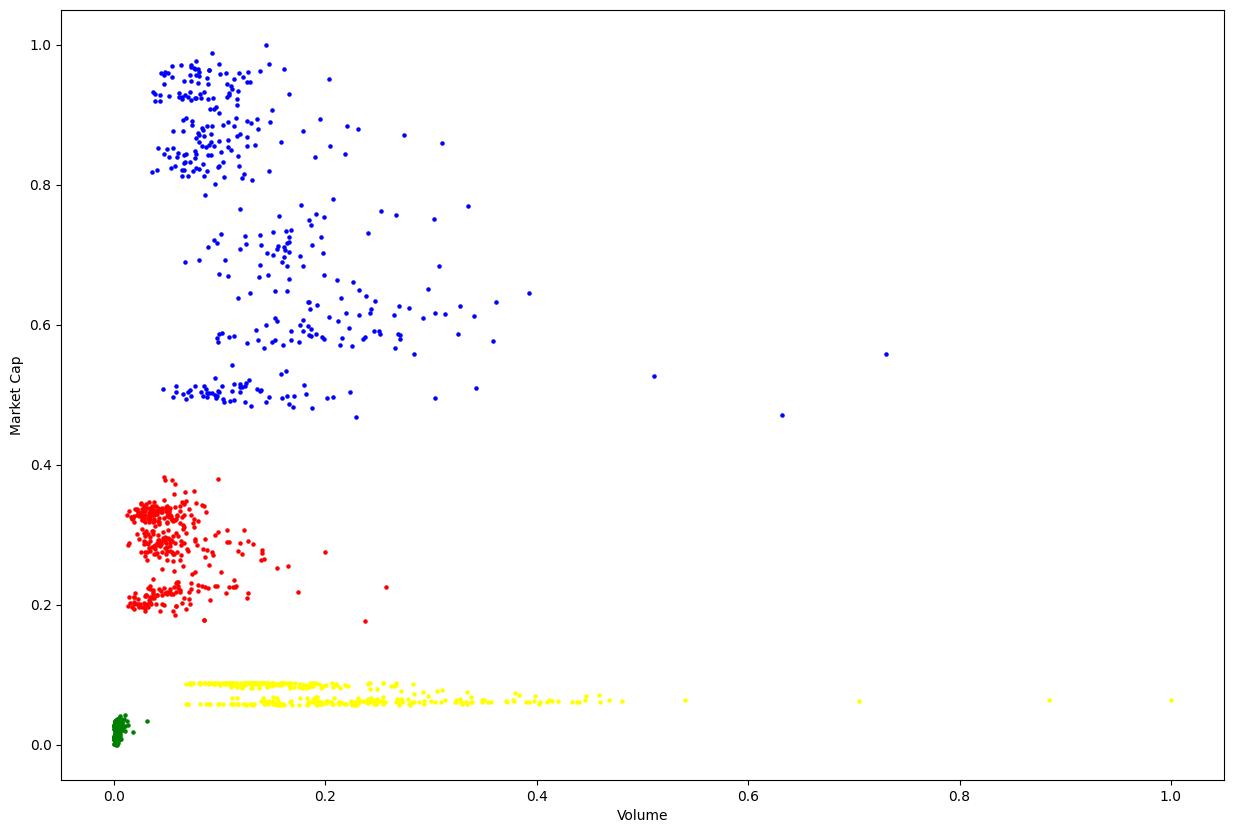

In [345]:
plt.figure(figsize=(15, 10))
plt.scatter(df[df['name'] == 'Bitcoin']['volume'], df[df['name'] == 'Bitcoin']['market_cap'], s=5, color='blue')
plt.scatter(df[df['name'] == 'BNB']['volume'], df[df['name'] == 'BNB']['market_cap'], s=5, color='green')
plt.scatter(df[df['name'] == 'Ethereum']['volume'], df[df['name'] == 'Ethereum']['market_cap'], s=5, color='red')
plt.scatter(df[df['name'] == 'Tether USDt']['volume'], df[df['name'] == 'Tether USDt']['market_cap'], s=5, color='yellow')
plt.xlabel('Volume')
plt.ylabel('Market Cap')
plt.show()

## 1-1 : KMeans Clustering

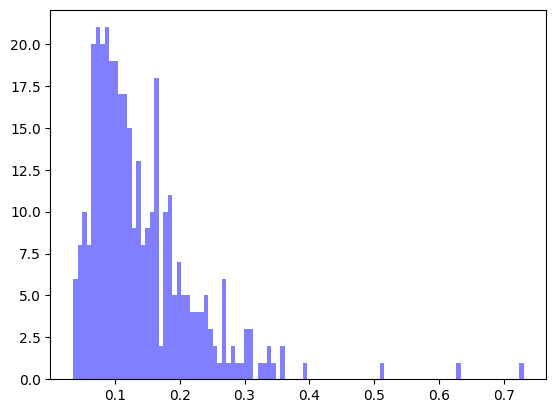

In [346]:
plt.hist(df[df['name'] == 'Bitcoin']['volume'], bins=100, color='blue', alpha=0.5)
plt.show()

In [347]:
#run kmeans clustering based on market cap and volume 
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5 , n_init=100 )
kmeans.fit(df[['market_cap', 'volume']])
df['cluster'] = kmeans.predict(df[['market_cap', 'volume']])

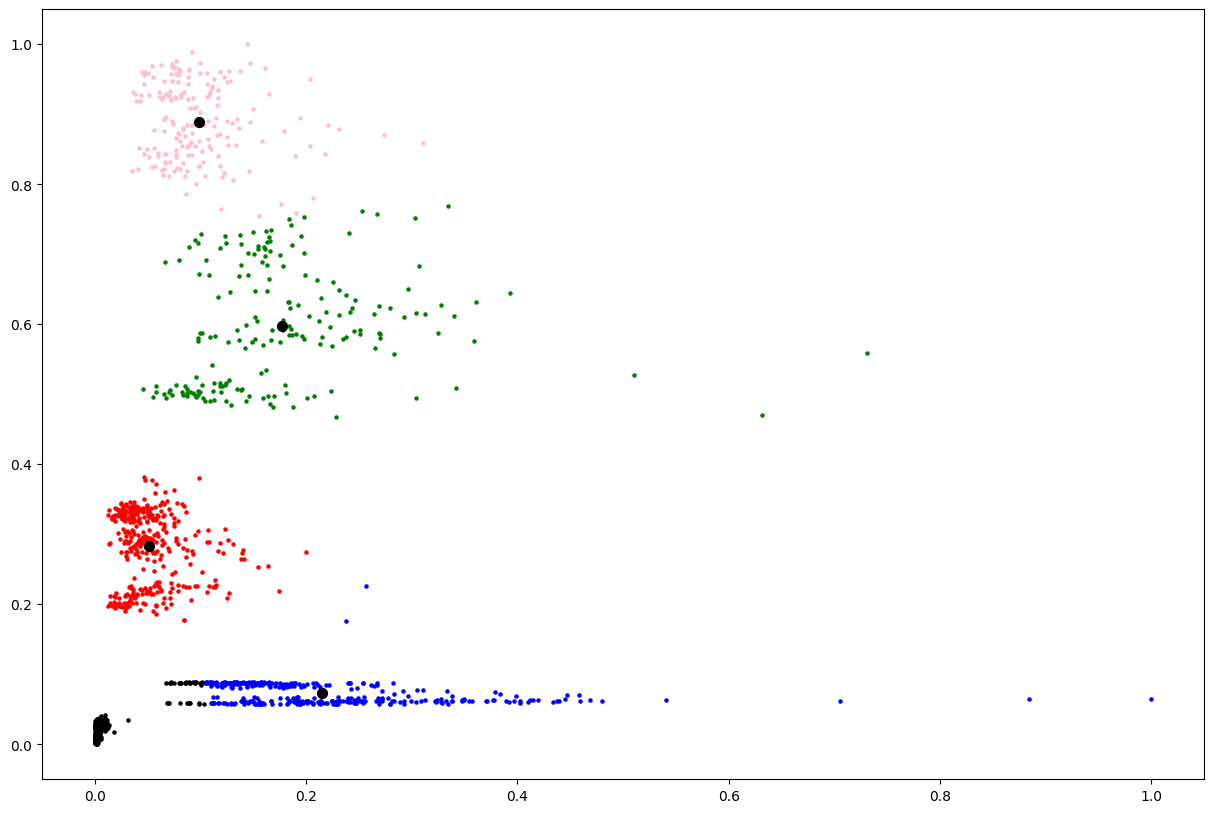

In [348]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df[df['cluster'] == 0]['volume'], df[df['cluster'] == 0]['market_cap'], s=5, color='blue')
plt.scatter(df[df['cluster'] == 1]['volume'], df[df['cluster'] == 1]['market_cap'], s=5, color='green')
plt.scatter(df[df['cluster'] == 2]['volume'], df[df['cluster'] == 2]['market_cap'], s=5, color='red')
plt.scatter(df[df['cluster'] == 3]['volume'], df[df['cluster'] == 3]['market_cap'], s=5, color='pink')
plt.scatter(df[df['cluster'] == 4]['volume'], df[df['cluster'] == 4]['market_cap'], s=5, color='black')
plt.scatter(kmeans.cluster_centers_[:, 1], kmeans.cluster_centers_[:, 0], color='black', marker='o', s=50)
plt.show()

## 1-2 Finding Optimal K

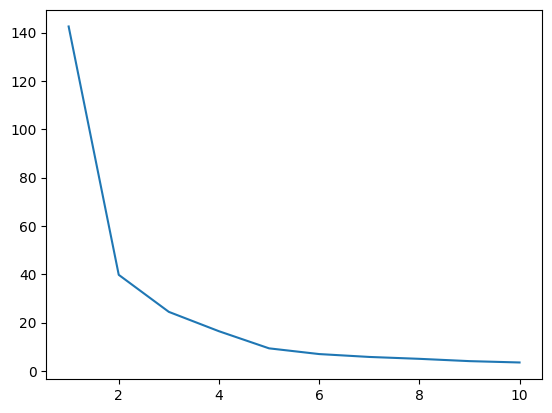

In [349]:
#run this for k =1 to k = 10 and calculate within cluster sum of squares
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df[['market_cap', 'volume']])
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)

as you can see, elbow method can't help because of the shape of the graph. so we use silhouette method instead.

In [350]:
from sklearn.metrics import silhouette_score
K_range = range(2, 13)
silhouette_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    silhouette_avg = silhouette_score(df_mm[['market_cap', 'volume']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

optimal_K = K_range[silhouette_scores.index(max(silhouette_scores))]

print("Optimal K: ", optimal_K)

Optimal K:  4


Testing davies_bouldin_score

In [351]:
from sklearn.metrics import davies_bouldin_score
K_range = range(2, 11)
dbi_scores = []

for K in K_range:
    kmeans = KMeans(n_clusters=K)
    cluster_labels = kmeans.fit_predict(df_mm[['market_cap', 'volume']])
    dbi = davies_bouldin_score(df_mm[['market_cap', 'volume']], cluster_labels)
    dbi_scores.append(dbi)

# Find the K with the lowest Davies-Bouldin Index
optimal_K = K_range[np.argmin(dbi_scores)]
min_dbi = min(dbi_scores)
print(f"Optimal K according to Davies-Bouldin Index: {optimal_K}")
# print(f"Minimum Davies-Bouldin Index: {min_dbi}")

Optimal K according to Davies-Bouldin Index: 4


Testing GaussianMixture

In [352]:
from sklearn.mixture import GaussianMixture
K_range = range(2, 11)
bic_scores = []

for K in K_range:
    gmm = GaussianMixture(n_components=K)
    gmm.fit(df_mm[['market_cap', 'volume']])
    bic = gmm.bic(df_mm[['market_cap', 'volume']])
    bic_scores.append(bic)

optimal_K = K_range[np.argmin(bic_scores)]
min_bic = min(bic_scores)

print(f"Optimal K according to BIC: {optimal_K}")

Optimal K according to BIC: 10


## 1-3 : Clustering with DBSCAN

### Normalization Using MinMaxScaler

In [353]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_mm[['volume','market_cap']] = scaler.fit_transform(df[['volume','market_cap']])

In [354]:
# dbscan = DBSCAN(eps=0.04, min_samples=15, metric='correlation')
# {'euclidean', 'precomputed', 'correlation', 'rogerstanimoto', 'canberra', 'sqeuclidean', 'nan_euclidean',
# 'seuclidean', 'wminkowski', 'sokalmichener', 'hamming', 'l1', 'russellrao', 'chebyshev', 
# 'cosine', 'sokalsneath', 'minkowski', 'cityblock', 'mahalanobis', 'manhattan', 'jaccard', 'haversine', 'kulsinski', 
# 'dice', 'yule', 'l2', 'matching', 'braycurtis'}

#dbscan = DBSCAN(eps=0.0366482344, min_samples=5, metric='chebyshev')


In [355]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.040, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3  4 -1]
21


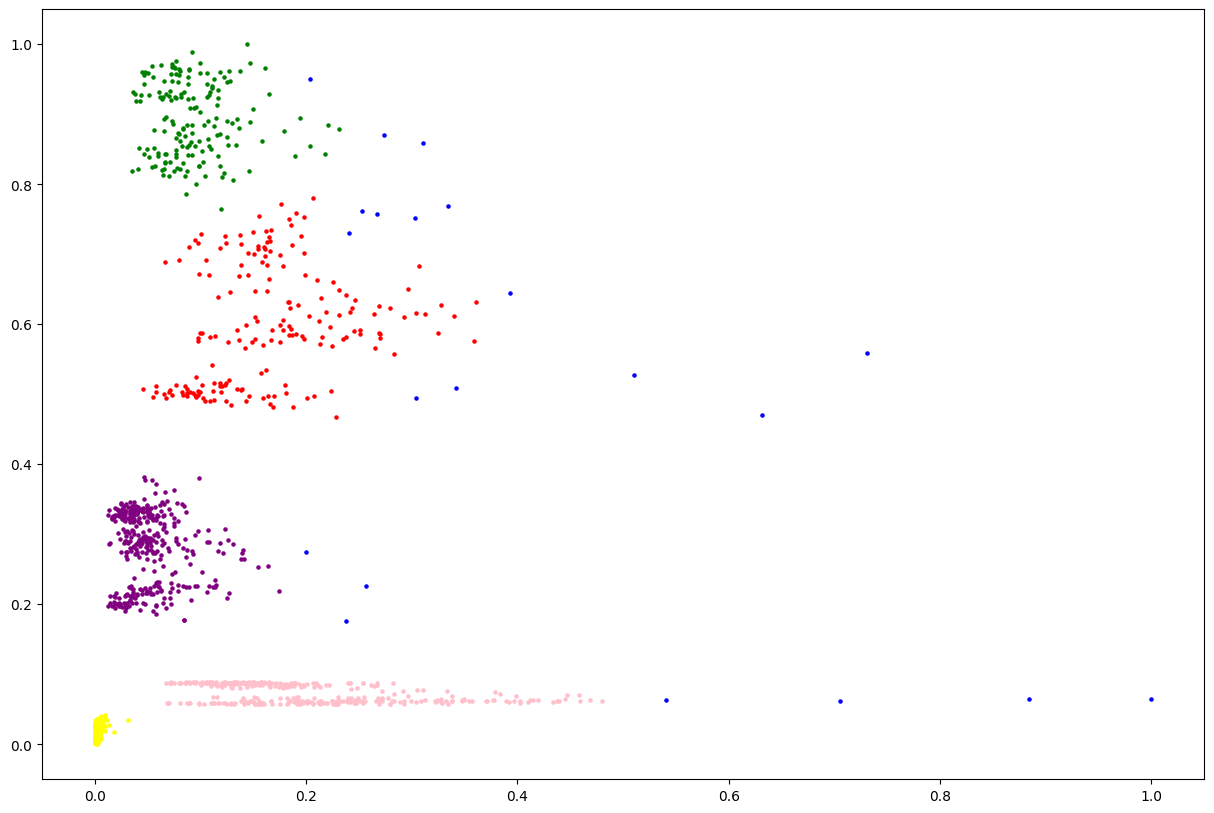

In [356]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')
# plt.scatter(df_mm[df_mm['cluster'] == 5]['volume'], df_mm[df_mm['cluster'] == 5]['market_cap'], s=5, color='black')
plt.show()

## Even better 

### (By using `0.041` as `eps`)

In [357]:
#run dbscan clustering based on market cap and volume
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.043, min_samples=5)
dbscan.fit(df_mm[['market_cap', 'volume']])
df_mm['cluster'] = dbscan.labels_
df_mm['cluster'].unique()
print(df_mm['cluster'].unique())
print((df_mm['cluster'] == -1).sum())

[ 0  1  2  3 -1]
20


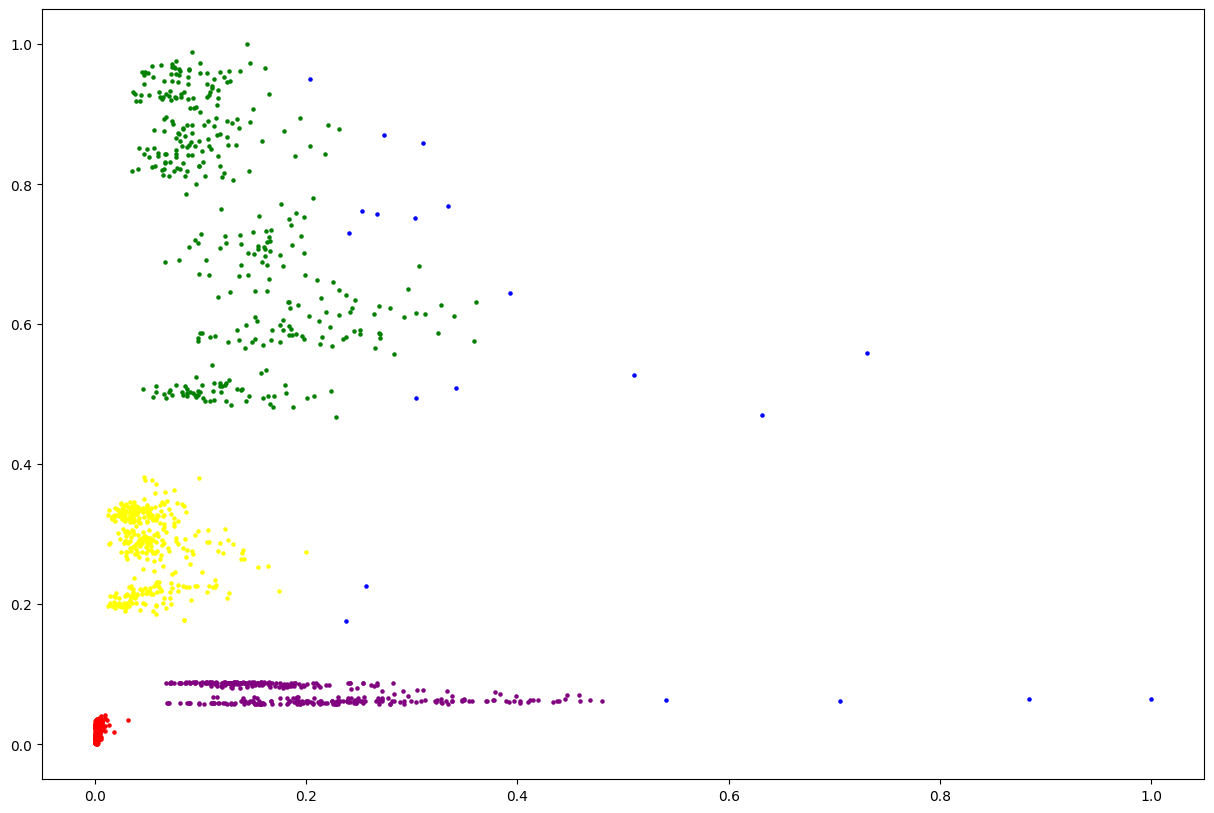

In [358]:
#plot the clusters
plt.figure(figsize=(15, 10))
plt.scatter(df_mm[df_mm['cluster'] == -1]['volume'], df_mm[df_mm['cluster'] == -1]['market_cap'], s=5, color='blue')
plt.scatter(df_mm[df_mm['cluster'] == 0]['volume'], df_mm[df_mm['cluster'] == 0]['market_cap'], s=5, color='green')
plt.scatter(df_mm[df_mm['cluster'] == 1]['volume'], df_mm[df_mm['cluster'] == 1]['market_cap'], s=5, color='red')
plt.scatter(df_mm[df_mm['cluster'] == 2]['volume'], df_mm[df_mm['cluster'] == 2]['market_cap'], s=5, color='yellow')
plt.scatter(df_mm[df_mm['cluster'] == 3]['volume'], df_mm[df_mm['cluster'] == 3]['market_cap'], s=5, color='purple')
plt.scatter(df_mm[df_mm['cluster'] == 4]['volume'], df_mm[df_mm['cluster'] == 4]['market_cap'], s=5, color='pink')


<font color="red">TO Know ^  Why this Works . </font>


# Part 2

In [359]:
df2 = pd.read_csv('coins_data.xlsx - Sheet1.csv')

In [360]:
df2.head(5)

,Symbol,Volume,MarketCap,TotalSupply,ProofType,Network
0,LEO,1.823284e+06,3586504072,"985,239,504",PoS,Ethereum
1,UNI,9.918768e+07,3992451215,"1,000,000,000",PoS,Ethereum
2,WBTC,1.415410e+08,4237575489,"163,106",PoW,Ethereum
3,AVAX,2.197065e+08,4901630273,"431,804,080",PoS,Avalanche
4,DAI,2.177113e+08,5513660644,"5,347,888,596",stablecoin,Ethereum


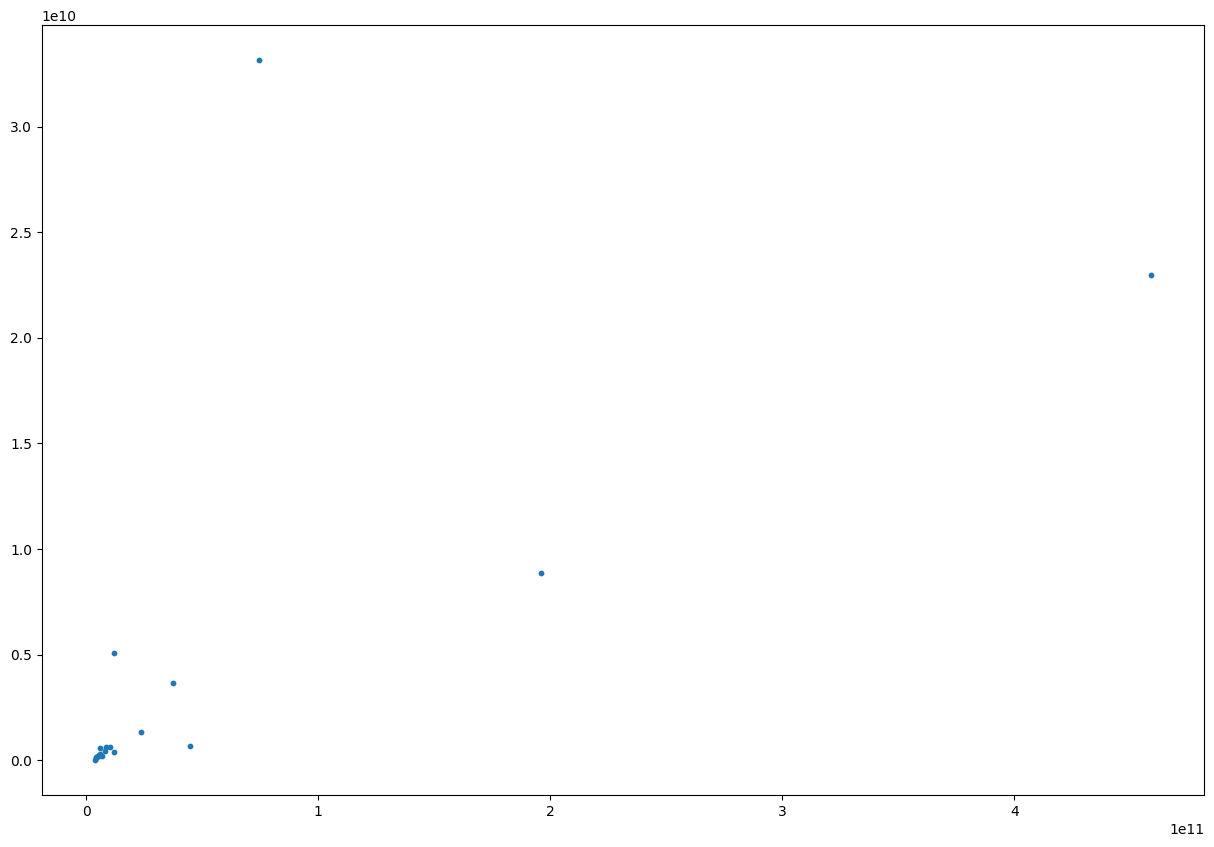

In [361]:
plt.figure(figsize=(15, 10))
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10)

### 2-1 : Hierarchical Clustering

### Normalization Using StandardScaler

In [362]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df2[['Volume','MarketCap']] = scaler.fit_transform(df2[['Volume','MarketCap']])

### Calculating the linkage matrix

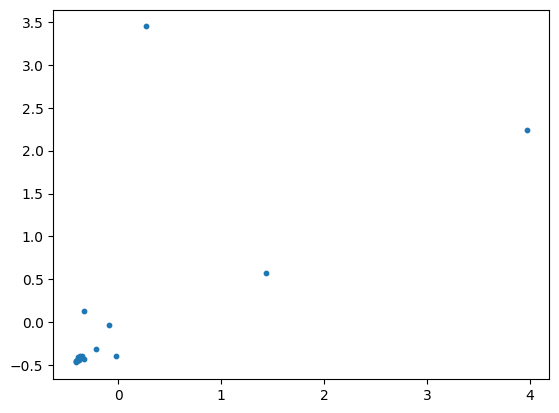

In [363]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# pairwise distances between data points
distances = pdist(df2[['MarketCap', 'Volume']], metric='euclidean')
square_distances = squareform(distances)
plt.scatter(df2['MarketCap'], df2['Volume'] , s=10 )

In [364]:
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')

### Plotting the dendrogram

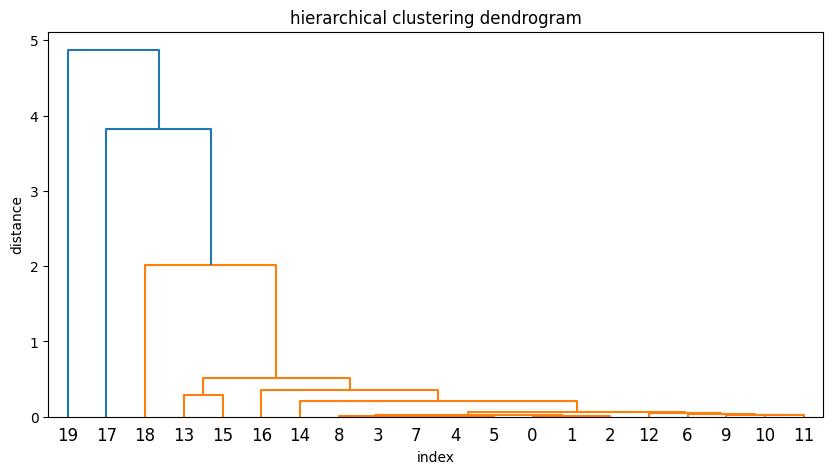

In [365]:
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

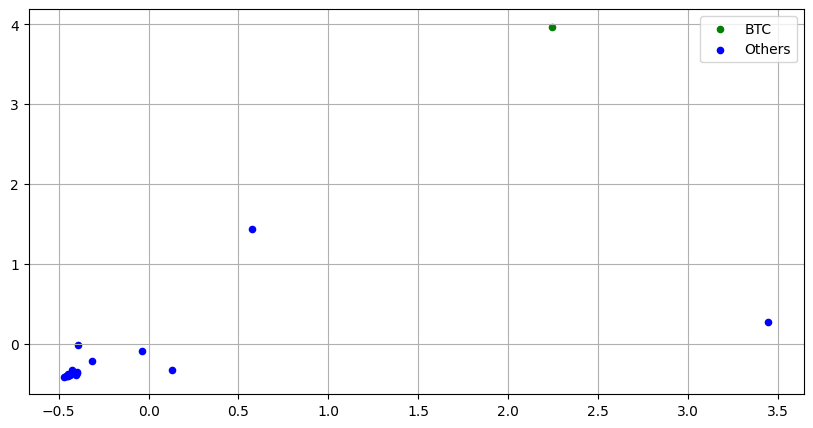

In [366]:
cluster_assignments = fcluster(linkage_matrix, t=4, criterion='distance')
# print(cluster_assignments)
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[-1]['Symbol'])
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

In [367]:
# #make a 3d plot for volume, market cap and prooftype
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(15, 10))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(df2['Volume'], df2['MarketCap'], df2['ProofType'], s=5)
# ax.set_xlabel('Volume')
# ax.set_ylabel('Market Cap')
# ax.set_zlabel('ProofType')
# plt.show()


## 2-2 : Adding `ProofType` to the data

### Using label encoder to encode `ProofType`

In [368]:
# now cluster based on volume, market cap and proof type using dendogram
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df2['ProofType'] = encoder.fit_transform(df2['ProofType'])

### Calculating the linkage matrix and plotting the dendrogram

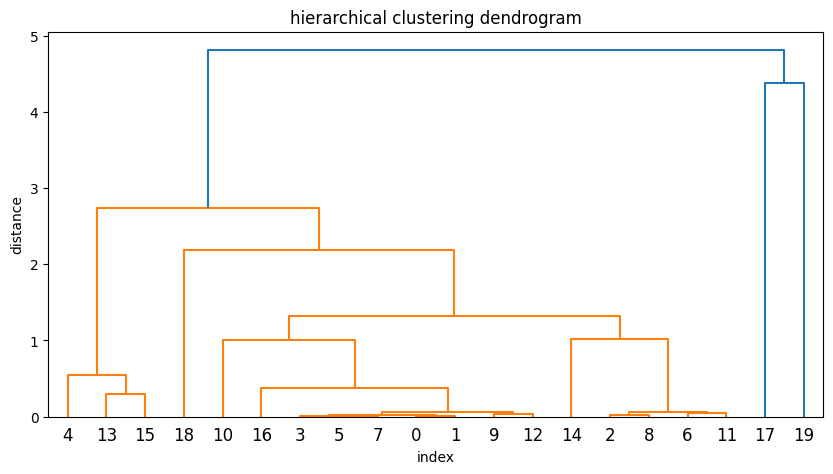

In [369]:
# now do the clustering
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

<font color="red">TODO ^ , is it important to use squareform twice ? <br> ARE </font>


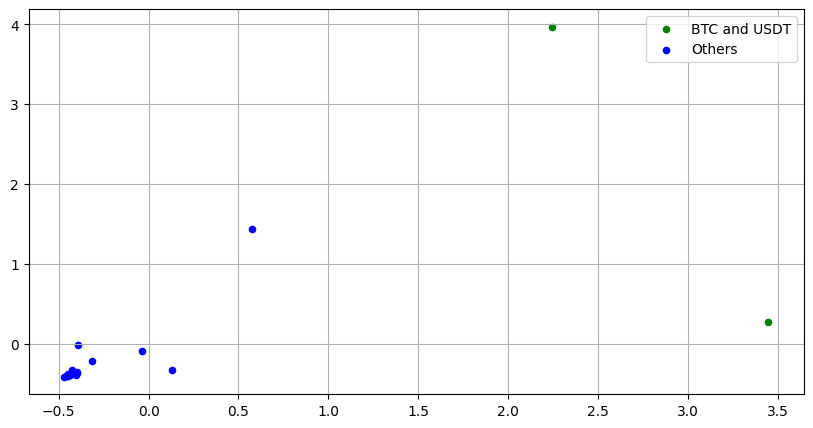

In [370]:
cluster_assignments = fcluster(linkage_matrix, t=4.5, criterion='distance')
df2['Cluster'] = cluster_assignments
#plot the clusters
plt.figure(figsize=(10, 5))
plt.scatter(df2[df2['Cluster'] == 2]['Volume'], df2[df2['Cluster'] == 2]['MarketCap'], s=20, color='green' , label=df2.iloc[19]['Symbol']+" and "+df2.iloc[17]['Symbol'] )
plt.scatter(df2[df2['Cluster'] == 1]['Volume'], df2[df2['Cluster'] == 1]['MarketCap'], s=20, color='blue' , label='Others')
plt.grid(True)
plt.legend()
df2.drop('Cluster' , axis=1, inplace=True)

## 2-3 : Adding more features to the data

In [371]:
encoder_n = LabelEncoder()
df2['Network'] = encoder_n.fit_transform(df2['Network'])

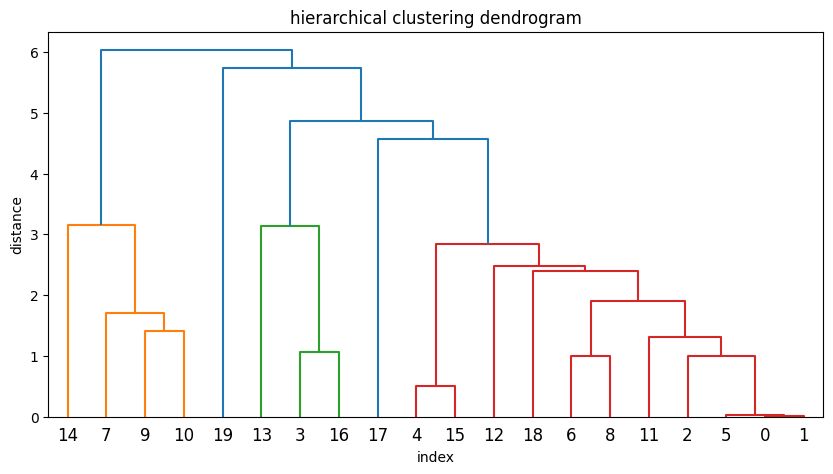

In [372]:
distances = pdist(df2[['MarketCap', 'Volume', 'ProofType' , 'Network']], metric='euclidean')
square_distances = squareform(distances)
# plt.scatter(df2['MarketCap'], df2['Volume'])
condensed_distances = squareform(square_distances)
linkage_matrix = linkage(condensed_distances, method='average')
plt.figure(figsize=(10, 5))
dendrogram(linkage_matrix, labels=df2.index)
plt.xlabel('index')
plt.ylabel('distance')
plt.title('hierarchical clustering dendrogram')
plt.show()

In [373]:
cluster_assignments = fcluster(linkage_matrix, t=5.8, criterion='distance')
df2['Cluster'] = cluster_assignments

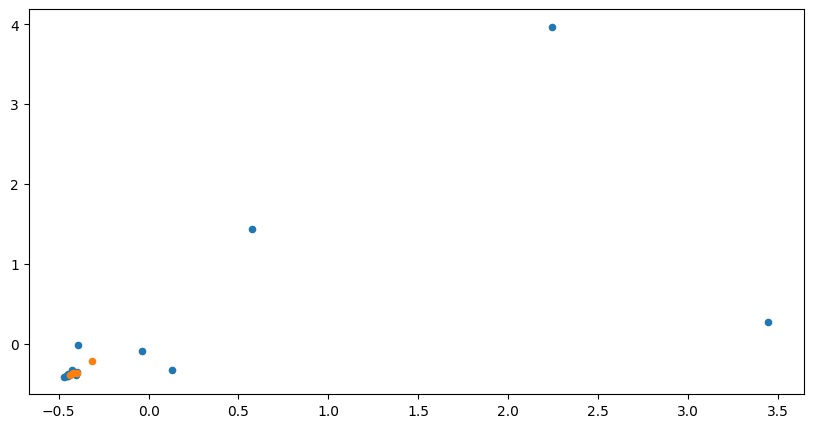

In [374]:
plt.figure(figsize=(10, 5))
for i in df2['Cluster'].unique():
    plt.scatter(df2[df2['Cluster'] == i]['Volume'], df2[df2['Cluster'] == i]['MarketCap'], s=20, label=i)



In [375]:
#make an interactive 3D plot
import plotly.express as px
fig = px.scatter_3d(df2, x='Volume', y='MarketCap', z='ProofType', color='Cluster')
fig.show()


<font color="red">TODO ^ <br> 3d plot rasm she , additional feature </font>


<h2 style="text-align:center;color:#0099cc;">Part 3</h2>
<p>The goal of this project is to predict the price change of XMR coin using machine learning. We are going to to compare each day's close price and the next day close price so that we would be able to classify our data into 2 groups of either experienced price increases or decreases.
</p>
<p>We also used a variety of machine learning models and evaluated their performance using various metrics.<p>

In [376]:
import pandas as pd

<h2 style="text-align:center;color:#0099cc;">Data Collection</h2>
<p>We collected data consisting of Monero cryptocurrency data with daily intervals for all available days, Monero cryptocurrency network information including its hash rate and difficulty, and Bitcoin financial information.


Please note that these are just a simple approaches and there are many other factors that can affect XMR's price.
</p>

<h3 align="left" style="color:#0099cc;">XMR & BTC Financial Information</h3>
We have used the `yfinance` library to extract data of XMR and BTC coins. `yfinance` is a Python library that allows us to download historical market data from Yahoo! Finance's API. It offers a threaded and Pythonic way to download market data from Yahoo! finance. We can use it to access ticker data in a more Pythonic way, get historical market data, show meta information about the history, show actions (dividends, splits, capital gains), show financials (income statement, balance sheet, cash flow statement), show holders, show options expirations, and more.

To predict the price of XMR in our model and see if BTC's price of the day affects XMR price change or not, we can use the extracted XMR and BTC data as features in our model. We can use BTC's price of the day as one of the features in our feature matrix and see if it has any effect on XMR's price. 

In [377]:
import yfinance as yf

xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers = "XMR-USD",period = "max",interval = "1d")
df_btc = yf.download(tickers="BTC-USD", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


<h3 align="left" style="color:#0099cc;"> XMR Hash Rate</h3>
<p>We collected data from <a href="https://drive.google.com/file/d/11NUjXNzuFnBd0MShJYq-RlrFeepMHUrA/view">this link</a> as df_hash. The data included features such as time_stamp, hash, time. We kept the hash column because we wanted to see the connection between XMR hash rate and its price change. Then we converted 'time' column to datetime using only its date information as index of df_hash and foreign key of df_xmr. </p>


In [378]:
df_hash = pd.read_csv('XMR_hash.csv')
df_hash.drop('Unnamed: 0' , axis=1 , inplace=True)
df_hash.drop('time_stamp' , axis=1 , inplace=True)
df_hash['Date'] = pd.to_datetime(df_hash['time']).dt.date
df_hash.drop('time' , axis=1 , inplace=True)
df_hash = df_hash.set_index('Date')
df_hash.index = pd.to_datetime(df_hash.index)
df_hash = df_hash[(df_hash.index >= '2017-11-09') & (df_hash.index <= '2023-10-08')]
df_hash = df_hash.groupby(df_hash.index).first()
df_hash

,hash
Date,
2017-11-09,2.338989e+08
2017-11-10,2.337782e+08
2017-11-11,2.337782e+08
2017-11-12,2.337782e+08
2017-11-13,2.337782e+08
...,...
2023-10-04,2.732839e+09
2023-10-05,2.838379e+09
2023-10-06,2.831227e+09


<h3 align="left" style="color:#0099cc;">XMR difficulty</h3>
<p>We collected data from <a href="https://drive.google.com/file/d/1WUNRZJgU0f5NaC-6Z0n_mMvt6P9yNV1U/view">this link</a> as df_dif. The data consists of features such as time_stamp, difficulty, time; Same as df_hash, we kept difficulty column as main column,and used date of 'time' column as df_dif index and df_xmr foreign key. </p>


In [379]:
df_dif = pd.read_csv('XMR_difficulty.csv')
df_dif.drop('Unnamed: 0' , axis=1 , inplace=True)
df_dif.drop('time_stamp' , axis=1 , inplace=True)
df_dif['Date'] = pd.to_datetime(df_dif['time']).dt.date
df_dif.drop('time' , axis=1 , inplace=True)
df_dif = df_dif.set_index('Date')
df_dif.index = pd.to_datetime(df_dif.index)
df_dif = df_dif[(df_dif.index >= '2017-11-09') & (df_dif.index <= '2023-10-08')]
df_dif = df_dif.groupby(df_dif.index).first()
df_dif

,difficulty
Date,
2017-11-09,2.806786e+10
2017-11-10,2.805339e+10
2017-11-11,2.805339e+10
2017-11-12,2.805339e+10
2017-11-13,2.805339e+10
...,...
2023-10-04,3.279407e+11
2023-10-05,3.406055e+11
2023-10-06,3.397473e+11


<style>
h1:first-of-type {
    margin-top: 2em;
}
</style>
<h1 style="text-align:center;color:#0099cc;">Data Preprocessing</h1>
<p>We performed various preprocessing steps on the data, including imputing missing values, column deduplication, dataframe selection, dataframe concatenation, target variable selection, scaling the features, data balancing and Train Test Split method.<p>

<h3 align="left" style="color:#0099cc;">Missing Data Imputation</h3>

<p>We aimed to impute the missing values of XMR dataframe and BTC dataframe. First, we checked to see if there were any missing values so that we could replace NAN values with the best possible values. But then, as the result is displayed, there were no missing values in both data frames.</p>

In [380]:
print('NAN value of XMR dataframe:\n', df_xmr.isna().sum())
print('\n\nNAN value of BTC dataframe:\n', df_btc.isna().sum())

NAN value of XMR dataframe:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


NAN value of BTC dataframe:
 Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


<h3 align="left" style="color:#0099cc;">Column Deduplication</h3>

<p>We did column deduplication because the duplicated columns, both have the same effect on predicting the target vector (XMR price change). Therefore, we can remove them from the feature matrix.</p>

In [381]:
def check_columns(df, col1, col2):
    return df[col1].equals(df[col2])

print('XMR: ', check_columns(df_xmr, 'Close', 'Adj Close'))
print('BTC: ', check_columns(df_xmr, 'Close', 'Adj Close'))

XMR:  True
BTC:  True


In [382]:
df_xmr.drop('Adj Close' , axis=1 , inplace=True)
df_btc.drop('Adj Close' , axis=1 , inplace=True)

<h3 align="left" style="color:#0099cc;">Dataframe Selection</h3>

<p>We were asked to evaluate our final model using data from 2023-09-08 to 2023-10-07 as the test set. That is, our last test sample contains the information of 07-10-2023 and the target variable label is determined according to the comparison with the closing price of 08-10-2023.</p>
<p>So it is clear that we just need data up to 2023-09-08 and we need to not include the data generated after 2023-09-08.</p>

In [383]:
df_combined = pd.merge(df_xmr, df_btc, on="Date", how="inner")
df_combined.drop(df_combined[df_combined.index > '2023-10-08'].index, inplace=True)
df_combined = pd.merge(df_combined, df_hash, on="Date", how="inner")
df_combined = pd.merge(df_combined, df_dif, on="Date", how="inner")
df_combined

,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y,hash,difficulty
Date,,,,,,,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,86864600,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,2.338989e+08,2.806786e+10
2017-11-10,121.344002,121.665001,101.757004,105.585999,84614000,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,2.337782e+08,2.805339e+10
2017-11-11,105.750000,127.106003,103.877998,119.615997,107708000,6618.609863,6873.149902,6204.220215,6357.600098,4908680192,2.337782e+08,2.805339e+10
2017-11-12,119.597000,133.675003,110.617996,123.856003,144948000,6295.450195,6625.049805,5519.009766,5950.069824,8957349888,2.337782e+08,2.805339e+10
2017-11-13,128.960007,136.528000,120.921997,123.402000,116200000,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,2.337782e+08,2.805339e+10
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-04,147.168442,150.702347,145.940781,150.469055,59400400,27429.074219,27826.658203,27248.105469,27799.394531,11143355314,2.732839e+09,3.279407e+11
2023-10-05,150.474197,151.328369,148.565491,149.623718,55704972,27798.646484,28091.861328,27375.601562,27415.912109,11877253670,2.838379e+09,3.406055e+11
2023-10-06,149.623337,152.669296,148.641647,151.992264,49535004,27412.123047,28252.537109,27215.552734,27946.597656,13492391599,2.831227e+09,3.397473e+11


<p>Then we decided to drop columns that are less likely to affect the price change of XMR coin such as 'Open_x', 'High_x', 'Low_x', 'Open_y', 'High_y', and 'Low_y'. For example, the 'Open' column is just the 'Close' column value of the previous day shifted one row. The 'High' and 'Low' column values indicate the price fluctuations during the day, but we are looking for the closed price of each day because maybe we have a really high value during a day compared to the previous day's close price, but in the end of the day, we experience a price reduction compared to the previous day's close price.</p>

In [384]:
df_combined.drop(['Open_x','High_x','Low_x','Open_y','High_y','Low_y'] , axis=1 , inplace=True)
df_combined

,Close_x,Volume_x,Close_y,Volume_y,hash,difficulty
Date,,,,,,
2017-11-09,120.779999,86864600,7143.580078,3226249984,2.338989e+08,2.806786e+10
2017-11-10,105.585999,84614000,6618.140137,5208249856,2.337782e+08,2.805339e+10
2017-11-11,119.615997,107708000,6357.600098,4908680192,2.337782e+08,2.805339e+10
2017-11-12,123.856003,144948000,5950.069824,8957349888,2.337782e+08,2.805339e+10
2017-11-13,123.402000,116200000,6559.490234,6263249920,2.337782e+08,2.805339e+10
...,...,...,...,...,...,...
2023-10-04,150.469055,59400400,27799.394531,11143355314,2.732839e+09,3.279407e+11
2023-10-05,149.623718,55704972,27415.912109,11877253670,2.838379e+09,3.406055e+11
2023-10-06,151.992264,49535004,27946.597656,13492391599,2.831227e+09,3.397473e+11


<h3 align="left" style="color:#0099cc;">Target Variable Selection</h3>

<p>We generated the target vector by labeling our data.</p>
<p>It was quoted in the project that:

<em>We want you to train a model that, according to the information received from today (which can also include information from previous days), predicts whether the price of Monero cryptocurrency (Monero or XMR) will increase or decrease in the next day compared to today? By price we mean the closing price. So your model should predict whether the closing price of the next day will be higher than today?</em></p>
<p>Accordingly we compared each date's close value with the same value of tomorrow and if the price was less than tomorrow we labeled the row as 0, otherwise we labeled the row as 1. Afterward we added these labels as numerical values to a new column in df_combines as 'Label'.</p>


In [385]:
df_combined['Label'] = (df_combined['Close_x'].shift(-1) > df_combined['Close_x']).astype(int)

In [386]:
df_combined[['Close_x','Label']]

,Close_x,Label
Date,,
2017-11-09,120.779999,0
2017-11-10,105.585999,1
2017-11-11,119.615997,1
2017-11-12,123.856003,0
2017-11-13,123.402000,0
...,...,...
2023-10-04,150.469055,0
2023-10-05,149.623718,1
2023-10-06,151.992264,1


<p>After comparing the 2023-10-07 price with the next day close price, we dropped the 2023-10-08 as well.</p>

In [387]:
df_combined.drop(df_combined[df_combined.index > '2023-10-07'].index, inplace=True)

<p>Here is the histogram of all columns except 'Label' column, plotting the distribution of mentioned columns:</p>

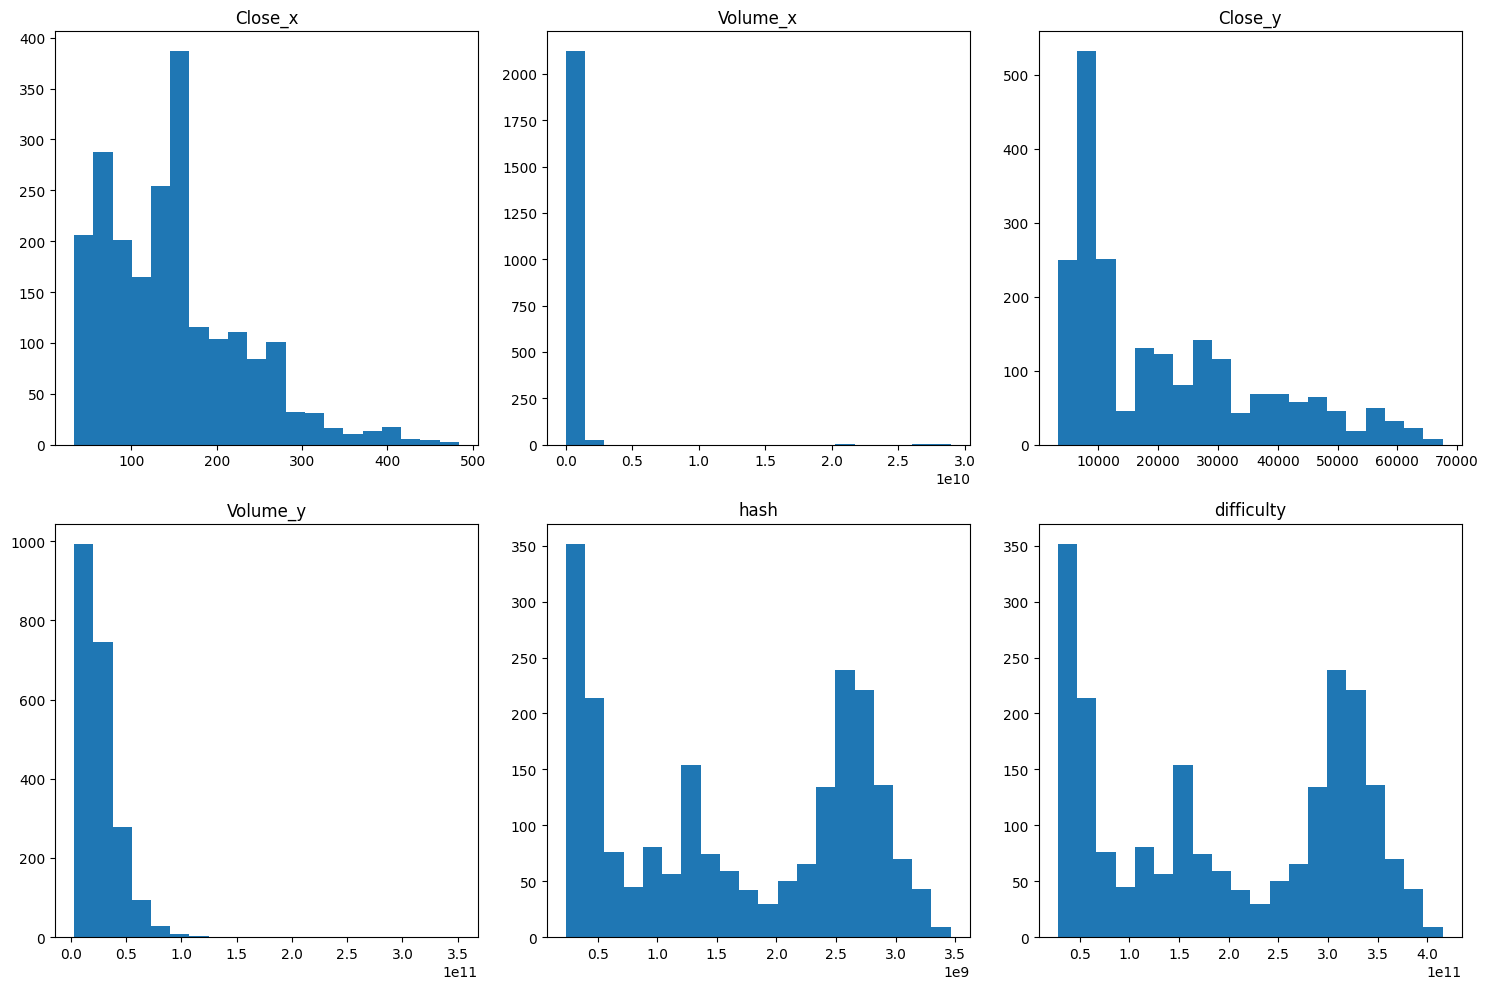

In [388]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
for i, col in enumerate(df_combined.columns[:-1]):
    axs[i//3, i%3].hist(df_combined[col], bins=20)
    axs[i//3, i%3].set_title(col)

plt.tight_layout()
plt.show()

<h3 align="left" style="color:#0099cc;">Features Scaling</h3>

<p>Numerous experiments show that usually when the scales of the features are similar to each other, the learning and final performance of the machine learning algorithm is better than when the features have different scales. If the scale of the features is not matched, the features with a larger variation range will play a much greater role in the estimation of the target variable. That is, the model considers more value for them, although it may not be the right decision. <a href="https://www.analyticsvidhya.com/blog/2020/04/feature-scaling-machine-learning-normalization-standardization/">[source]</a></p>
<p>Therefore, we decided to use Standardization method because the data is not uniformly distributed and it may cause some of our data to tend to zero or become zero in the dataset.</p>


In [389]:
from sklearn.preprocessing import StandardScaler , MinMaxScaler
scaler = StandardScaler()
df_combined[df_combined.columns[:-1]] = scaler.fit_transform(df_combined[df_combined.columns[:-1]])
df_combined

,Close_x,Volume_x,Close_y,Volume_y,hash,difficulty,Label
Date,,,,,,,
2017-11-09,-0.352803,-0.157013,-0.869556,-1.157004,-1.402161,-1.402448,0
2017-11-10,-0.540957,-0.159259,-0.902629,-1.052195,-1.402281,-1.402567,1
2017-11-11,-0.367217,-0.136213,-0.919028,-1.068036,-1.402281,-1.402567,1
2017-11-12,-0.314711,-0.099049,-0.944678,-0.853942,-1.402281,-1.402567,0
2017-11-13,-0.320333,-0.127738,-0.906320,-0.996407,-1.402281,-1.402567,0
...,...,...,...,...,...,...,...
2023-10-03,-0.026234,-0.194411,0.407317,-0.724361,1.342695,1.342759,1
2023-10-04,0.014851,-0.184421,0.430569,-0.738346,1.079280,1.079311,0
2023-10-05,0.004383,-0.188108,0.406432,-0.699537,1.184081,1.184125,1


<h3 align="left" style="color:#0099cc;">Data Balancing</h3>
<p>As it is observed from following result the data is reliably balanced.</p>

In [390]:
df_combined['Label'].value_counts(normalize=True)

Label
1    0.524186
0    0.475814
Name: proportion, dtype: float64

<style>
h1:first-of-type {
    margin-top: 2em;
}
</style>
<h1 style="text-align:center;color:#0099cc;">Model Selection</h1>
<p>In this section, we performed Model Selection, which is a critical step in the machine learning process. The purpose of model selection is to identify the most effective model from a set of potential models based on their performance. It helps us to choose the model that will not only fit the training data well but also generalize effectively to unseen data.<p>
<p>We used the Train/Test Split method to prevent overfitting.<p>
<p>For our project, we experimented with several machine learning models including Logistic Regression, Random Forests, Support Vector Machine (SVM), K-Nearest Neighbors (KNN), XGBoost, Naive Bayes and neural network. Each of these models was trained using the training data and then evaluated using the validation data. The performance of each model was assessed using metrics such as F1 score. Based on these evaluations, we were able to select the best performing model for our task and fit it on the test data.<p>

<h2 align="left" style="color:#0099cc;">Train/Test Split</h2>

<p>Before experimenting with several machine learning models, we split our data into training, validation and testing sets using the train-test split method. This approach ensures that we have a separate dataset to evaluate the performance of our models and prevent overfitting.</p>


In [391]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score , f1_score , classification_report , confusion_matrix, roc_auc_score
from sklearn.model_selection import GridSearchCV

<p>As it was stated in the project:

“In order to evaluate your final model, use the data from 09-08-2023 to 10-07-2023 as a test set.”

We form the test_data.<p>

In [392]:
test_data = df_combined[(df_combined.index >= '2023-09-08') & (df_combined.index <= '2023-10-07')]
X_test = test_data.drop('Label' , axis=1).to_numpy()
y_test = test_data['Label'].to_numpy()
test_data.shape

(30, 7)

In [393]:
df_train = df_combined.drop(test_data.index , axis=0)
X = df_train.drop('Label' , axis=1).to_numpy()
y = df_train['Label'].to_numpy()

In [394]:
X_train , X_val , y_train , y_val = train_test_split( X, y ,
                                                     test_size=0.2,
                                                     shuffle=False )

<p>This function reports the confusion matrix of each model<p>

In [395]:
def CReport(y_actual,y_predicted , s="F"):
    plt.figure(figsize=(6,6))
    cm=confusion_matrix(y_actual,y_predicted)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print("\n")
    print(classification_report(y_actual,y_predicted))
    if s!="F":
        print(f"Validation F1_Score: {f1_score(y_actual,y_predicted)}")
    else:
        print(f"Final F1_Score: {f1_score(y_actual,y_predicted)}")

<h2 align="left" style="color:#0099cc;">Logistic Regression</h2>


In [396]:
from sklearn.linear_model import LogisticRegression
ls = LogisticRegression(penalty='l2' , C=1 , max_iter=1000)
ls.fit(X_train , y_train)

LogisticRegression(C=1, max_iter=1000)

### CV evaluation

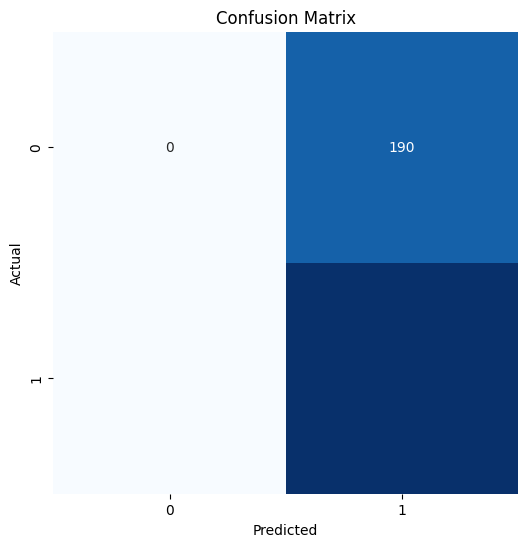



              precision    recall  f1-score   support

           0       0.00      0.00      0.00       190
           1       0.55      1.00      0.71       234

    accuracy                           0.55       424
   macro avg       0.28      0.50      0.36       424
weighted avg       0.30      0.55      0.39       424

Validation F1_Score: 0.7112462006079028
The AUC of the model is 0.50


In [397]:
y_pred = ls.predict(X_val)
CReport(y_val , y_pred , "V")
auc = roc_auc_score(y_val, y_pred)

print(f'The AUC of the model is {auc:.2f}')

<h2 align="left" style="color:#0099cc;">Random Forest</h2>


In [398]:
# rf classifier
from sklearn.ensemble import RandomForestClassifier
# model_rf = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [50, 100, 200],  
#     'max_features': ['log2', 'sqrt'], 
#     'max_depth': [ 10, 20, 30], 
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [2, 4],  
# }
# gs = GridSearchCV(model_rf , param_grid=param_grid , cv=3 , scoring='f1' , verbose=1)
# gs.fit(X_train , y_train )

In [399]:
# Make 'Close' feature more important to the model
# model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)
# model_rf.fit(X_train , y_train)

model_rf = RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)
model_rf.fit(X_train , y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=4, n_estimators=50)

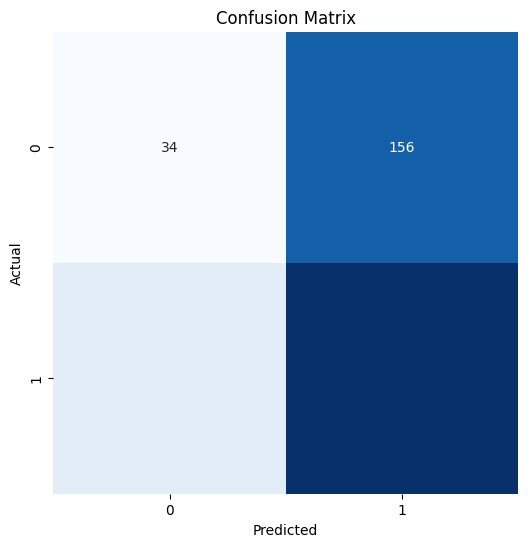



              precision    recall  f1-score   support

           0       0.40      0.18      0.25       190
           1       0.54      0.79      0.64       234

    accuracy                           0.51       424
   macro avg       0.47      0.48      0.44       424
weighted avg       0.48      0.51      0.47       424

Validation F1_Score: 0.6411149825783972
The AUC of the model is 0.50


In [400]:
y_pred = model_rf.predict(X_val)
CReport(y_val , y_pred , "V")
print(f'The AUC of the model is {auc:.2f}')

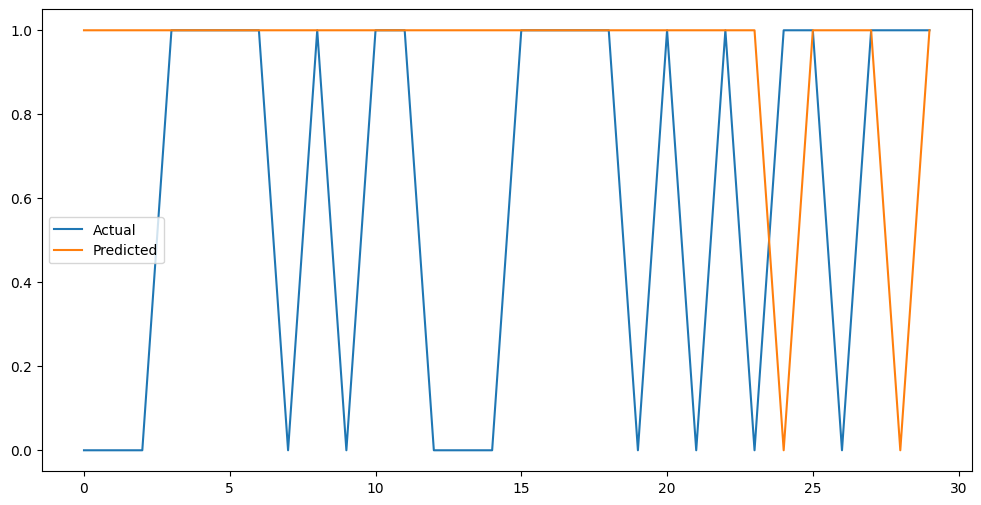

In [402]:
# plot predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

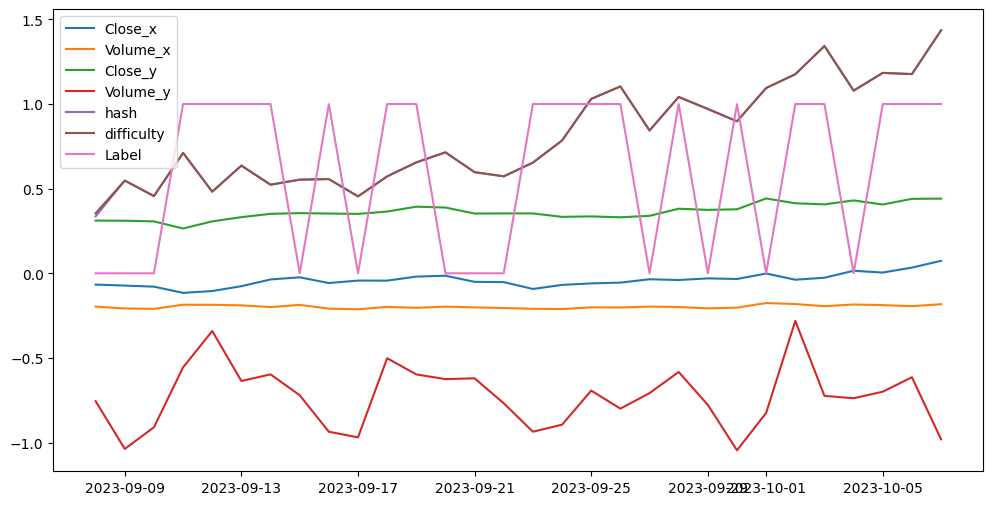

In [425]:
plt.figure(figsize=(12, 6))
plt.plot(test_data)
plt.legend(test_data.columns)

<h2 align="left" style="color:#0099cc;">Support Vector Machine (SVM)</h2>


In [404]:
# grid search for svc
from sklearn.svm import SVC
# model_svc = SVC()
# param_grid = {
#     'C': [0.1, 1, 10, 100],
#     'gamma': [1, 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'sigmoid']
# }
# gs = GridSearchCV(model_svc , param_grid=param_grid , cv=3 , scoring='f1' , verbose=1)
# gs.fit(X_train , y_train)

In [405]:
model_svm = SVC()
model_svm.fit(X_train , y_train)

SVC()

### CV evaluation

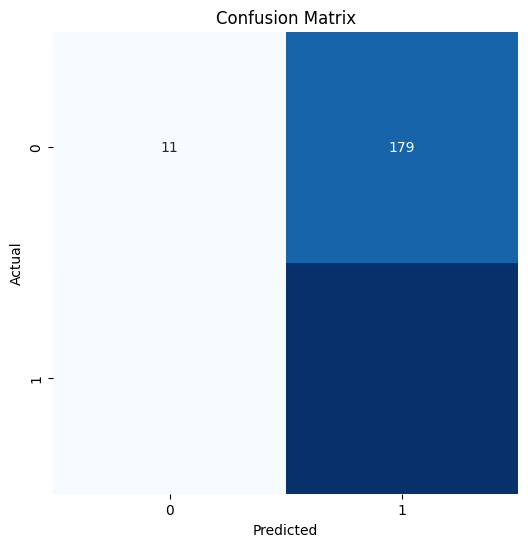



              precision    recall  f1-score   support

           0       0.46      0.06      0.10       190
           1       0.55      0.94      0.70       234

    accuracy                           0.55       424
   macro avg       0.51      0.50      0.40       424
weighted avg       0.51      0.55      0.43       424

Final F1_Score: 0.6971608832807571
The AUC of the model is 0.50


In [406]:
CReport(y_val , model_svm.predict(X_val))
print(f'The AUC of the model is {auc:.2f}')

<h2 align="left" style="color:#0099cc;">K-Nearest Neighbors (KNN)</h2>


In [408]:
# knn for this
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier()
model_knn.fit(X_train , y_train)


KNeighborsClassifier()

### CV evaluation

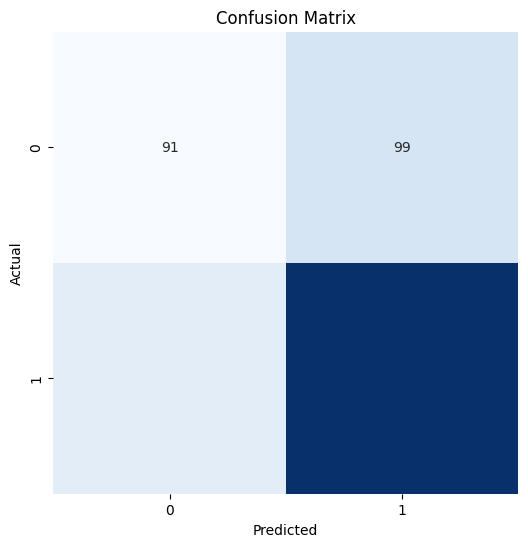



              precision    recall  f1-score   support

           0       0.49      0.48      0.48       190
           1       0.58      0.59      0.59       234

    accuracy                           0.54       424
   macro avg       0.53      0.53      0.53       424
weighted avg       0.54      0.54      0.54       424

Final F1_Score: 0.5859872611464968
The AUC of the model is 0.50


In [409]:
CReport(y_val , model_knn.predict(X_val))
print(f'The AUC of the model is {auc:.2f}')

<h2 align="left" style="color:#0099cc;">XGBoost</h2>


In [411]:
#XGBoost Classifier
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train , y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### CV evaluation

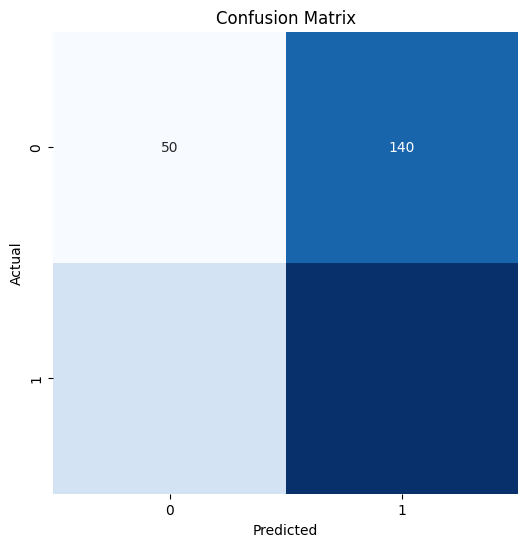



              precision    recall  f1-score   support

           0       0.41      0.26      0.32       190
           1       0.54      0.70      0.61       234

    accuracy                           0.50       424
   macro avg       0.48      0.48      0.46       424
weighted avg       0.48      0.50      0.48       424

Final F1_Score: 0.6070763500931099
The AUC of the model is 0.50


In [412]:
CReport(y_val , model_xgb.predict(X_val))
print(f'The AUC of the model is {auc:.2f}')

<h2 align="left" style="color:#0099cc;">Naive Bayes</h2>


In [414]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()
model_nb.fit(X_train , y_train)


GaussianNB()

### CV evaluation

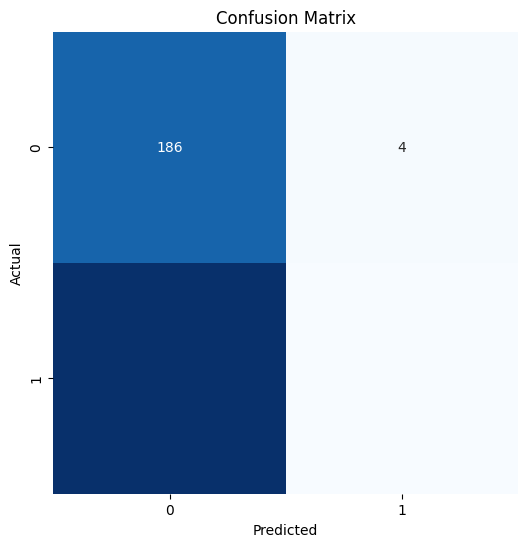



              precision    recall  f1-score   support

           0       0.44      0.98      0.61       190
           1       0.33      0.01      0.02       234

    accuracy                           0.44       424
   macro avg       0.39      0.49      0.31       424
weighted avg       0.38      0.44      0.28       424

Validation F1_Score: 0.016666666666666666
The AUC of the model is 0.50


In [415]:
CReport(y_val , model_nb.predict(X_val) , s="V")
print(f'The AUC of the model is {auc:.2f}')

<h1 align="center" style="color:#0099cc;">Final Decision</h1>


In [426]:
from sklearn.metrics import recall_score
df_f1 = pd.DataFrame(columns=['Model' , 'F1_Score' , 'Recall'])
df_f1['Model'] = ['Logistic Regression' , 'Random Forest' , 'SVM' , 'KNN' , 'XGBoost' , 'Naive Bayes']
df_f1['F1_Score'] = [f1_score(y_val , y_pred) , f1_score(y_val , y_pred) , f1_score(y_val , model_svm.predict(X_val)) , f1_score(y_val , model_knn.predict(X_val)) , f1_score(y_val , model_xgb.predict(X_val)) , f1_score(y_val , model_nb.predict(X_val))]
df_f1['Recall'] = [recall_score(y_val , y_pred) , recall_score(y_val , y_pred) , recall_score(y_val , model_svm.predict(X_val)) , recall_score(y_val , model_knn.predict(X_val)) , recall_score(y_val , model_xgb.predict(X_val)) , recall_score(y_val , model_nb.predict(X_val))]
df_f1 = df_f1.set_index('Model')
df_f1['IsValid'] = df_f1['Recall'].apply(lambda x : 'No' if x==1 else 'Yes')
df_f1.sort_values(by='F1_Score' , ascending=False , inplace=True)


In [427]:
df_f1

,F1_Score,Recall,IsValid
Model,,,
SVM,0.697161,0.944444,Yes
Logistic Regression,0.641115,0.786325,Yes
Random Forest,0.641115,0.786325,Yes
XGBoost,0.607076,0.696581,Yes
KNN,0.585987,0.589744,Yes
Naive Bayes,0.016667,0.008547,Yes


### Final Result
<p>As it is observed from the table above the best model was ......<p>

<h1 align="center" style="color:#0099cc;">Advanced Methods (Optional) : Neural Network</h1>
<p>A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. In other words, neural networks are computing systems with interconnected nodes that work much like neurons in the human brain. Using algorithms, they can recognize hidden patterns and correlations in raw data, cluster and classify it, and – over time – continuously learn and improve.<a href="https://www.ibm.com/topics/neural-networks">[source]</a><p>

In [419]:
import tensorflow as tf
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout , LSTM , LeakyReLU
from sklearn.utils.class_weight import compute_class_weight


<p>The compute_class_weight function is used to calculate class weights, which can be particularly useful when dealing with imbalanced datasets.The 'balanced' mode uses the values of y to automatically adjust weights inversely proportional to class frequencies. The function returns an array of weights, where each weight corresponds to a class. <p>

In [420]:
class_weights = compute_class_weight('balanced', classes=[0, 1],y=y_train)
class_weights

array([1.03288672, 0.96914286])

<p>Then we initialize the model:

- A Dense layer with 3 neurons and ReLU activation function

- A Dense layer with 1 neuron and sigmoid activation function

Afterward, the model is compiled with Adam optimizer, binary cross entropy as loss function and recall and precision as metrics. Finally, the model is fit to the training data for 10 epochs, with validation data provided, no verbosity and class weights specified

In [421]:
model_NN = Sequential([
    # LSTM(12, input_shape=(5, 12), activation='relu'),
    # Dense(40, activation='relu'),
    # Dropout(0.4),
    # Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    # Dropout(0.2),
    # Dense(64, activation='relu'),
    # Dense(16, activation='tanh'),
    # Dense(32, activation=LeakyReLU(alpha=0.15)),
    # Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model_NN.compile(optimizer='adam', loss='binary_crossentropy', metrics=[recall , precision])
model_NN.fit(X_train, y_train, epochs=10 , validation_data=(X_val, y_val) ,verbose=0 , class_weight={0: 1.02, 1: 0.99})

<P>Last but not least, the confusion matrix is plotted.

14/14 [==============================] - 0s 466us/step


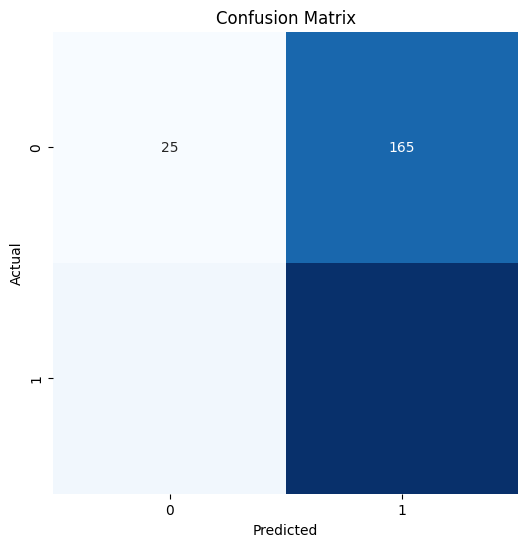



              precision    recall  f1-score   support

           0       0.45      0.13      0.20       190
           1       0.55      0.87      0.67       234

    accuracy                           0.54       424
   macro avg       0.50      0.50      0.44       424
weighted avg       0.50      0.54      0.46       424

Validation F1_Score: 0.6744186046511628


In [422]:
y_pred_nn = model_NN.predict(X_val)
y_pred_nn = np.round(y_pred_nn)
CReport(y_val , y_pred_nn , s="V")

1/1 [==============================] - 0s 17ms/step


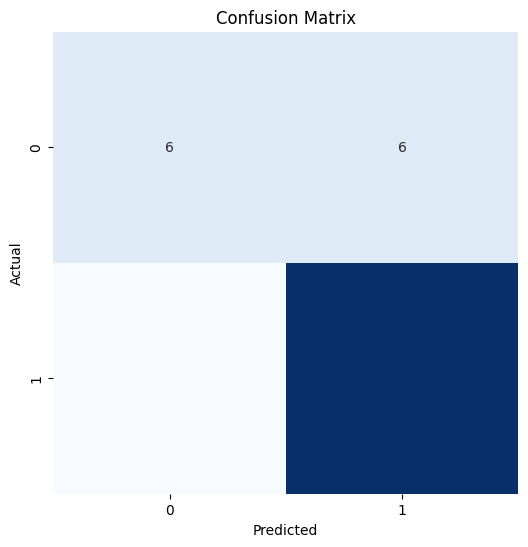



              precision    recall  f1-score   support

           0       0.55      0.50      0.52        12
           1       0.68      0.72      0.70        18

    accuracy                           0.63        30
   macro avg       0.61      0.61      0.61        30
weighted avg       0.63      0.63      0.63        30

Final F1_Score: 0.7027027027027027


In [423]:
y_pred_nn_final = model_NN.predict(X_test)
y_pred_nn_final = np.round(y_pred_nn_final)
CReport(y_test , y_pred_nn_final)